In [1]:
import csv
import pandas as pd
import shap
import sklearn
import numpy as np
import matplotlib
import interpret.glassbox
import xgboost
import time
import matplotlib.pylab as pl
from hyperopt.pyll.base import scope
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from xgbse.converters import (
    convert_data_to_xgb_format,
    convert_to_structured
)

# Hyperparameters tuning

from hyperopt import STATUS_OK, fmin, hp, tpe, SparkTrials

data = pd.read_csv('../cohort.csv')
# https://github.com/IyarLin/survXgboost get predictions instead of hazards

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
# data = data.sample(50000)
y = data
y = convert_to_structured(y['time'], y['event'])
y = [x[1] if x[0] else -x[1] for x in y]
X = data.drop(['time', 'event', 'charlson', 'cldl', 'htn_med', 'c10'], axis = 1)
event = data['time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
X_train, X_test, event_train, event_test = train_test_split(X, event, test_size=0.2, random_state=20)

In [3]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if int(labels[j]) > 0 and abs(int(labels[i])) > int(labels[j]):
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

In [4]:
SEED = 314159265
VALID_SIZE = 0.2
TARGET = 'outcome'
##############################################
def score_xgb(params):
    print("Training with params: ")
    print(params)
    
    n_folds = 5
    val_scores = []
    skf = KFold(n_splits = n_folds, shuffle = False)
    num_boost_round=1000
    #k-fold CV
    for train_index, val_index in skf.split(X_train): 
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = event.iloc[train_index], event.iloc[val_index]
        
        dtrain = xgboost.DMatrix(X_tr, label=y_tr)
        dval = xgboost.DMatrix(X_val, label=y_val)

        watchlist = [(dval, 'eval'), (dtrain, 'train')]
        gbm_model = xgboost.train(params, dtrain, num_boost_round,
                              evals=watchlist,
                                 verbose_eval=500)
        
        predictions = gbm_model.predict(dval,
                                    ntree_limit=gbm_model.best_iteration + 1)
        val_scores.append(c_statistic_harrell(predictions, list(y_val)))
    
    score = np.mean(val_scores) #Objective: maximize mean 5-fold CV C-index 
    
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


def optimize_xgb(score, 
             random_state=SEED):
    """
    This is the optimization function that given a space of 
    hyperparameters and a scoring function, finds the best hyperparameters.
    """

    # exception: min_child_weight, reg_alpha and reg_lambda capped at 10 rather than 100
    space = {
        'eta':                         hp.loguniform('eta', np.log(0.01), np.log(0.1)),
        'max_depth':                   scope.int(hp.quniform('max_depth', 2,3,1)),
        'min_child_weight':            hp.loguniform('min_child_weight', np.log(0.1), np.log(1)),
        'reg_alpha':                   hp.loguniform('reg_alpha', np.log(0.1), np.log(1)),
        'reg_lambda':                  hp.loguniform('reg_lambda', np.log(0.1), np.log(1)),
        'subsample':                   hp.uniform('subsample', 0.75, 1),
        "objective": "survival:cox",
        "predictor": "gpu_predictor"
    }
    
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                max_evals=100)
    return best

In [ ]:
print("---- Running XGBoost ----")
start=time.time()
xgb_best_hyperparams = optimize_xgb(score_xgb)
end=time.time()
print("Done: took", (end-start)/60, "minutes")
print("---- Results for XGBoost ----")
print("The best hyperparameters are: ", "\n")
print(xgb_best_hyperparams)

In [5]:
# {'eta': 0.06762699363611696, 'max_depth': 3.0, 'min_child_weight': 0.20842058329380173, 
# 'reg_alpha': 0.6022332107335537, 'reg_lambda': 0.35196063054332594, 'subsample': 0.7505628222490803}
params = {
    'eta': 0.07,
    "max_depth": 3,
    'min_child_weight': 0.2,
    'reg_alpha': 0.6,
    'reg_lambda': 0.51,
    "objective": "survival:cox",
    "subsample":  0.75,
    "predictor": "gpu_predictor"
}

In [6]:
num_boost_round=100000
dtrain = xgboost.DMatrix(X_train, label=y_train)
dval = xgboost.DMatrix(X_test, label=y_test)

watchlist = [(dtrain, 'train'), (dval, 'eval')]
# Xambiant l'ordre del watchlist el model es fa un lio amb algunes variables, tenim millors resultats deixat-ho aixi
# watchlist = [(dval, 'eval')]
# evals=[(train, "train"), (test, "validation")]
xgb_model = xgboost.train(params, 
                          dtrain, 
                          num_boost_round, 
                          early_stopping_rounds=1000,
                          evals=watchlist,
                          verbose_eval=500)

predictions = xgb_model.predict(dval, ntree_limit=xgb_model.best_iteration + 1)



xgb_test_score = c_statistic_harrell(predictions, list(y_test))
print("XGB Done:", xgb_test_score)
# 0.659

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	train-cox-nloglik:11.29691	eval-cox-nloglik:9.90987
[500]	train-cox-nloglik:11.01852	eval-cox-nloglik:9.78645
[1000]	train-cox-nloglik:10.93387	eval-cox-nloglik:9.80790
[1123]	train-cox-nloglik:10.91504	eval-cox-nloglik:9.81251


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


XGB Done: 0.6593222535793425


In [7]:
xgb_model.best_iteration

123

In [ ]:
# save to JSON
xgb_model.save_model("model_all.json")

In [ ]:
# xgb_model = xgboost.Booster()
# xgb_model.load_model("model_all.json")

In [17]:
# plot_importance(xgb_model)
# pyplot.show()

In [8]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X)

In [9]:
matplotlib.use('tkagg',force=True)
from matplotlib import pyplot as plt
matplotlib.get_backend()
%matplotlib inline

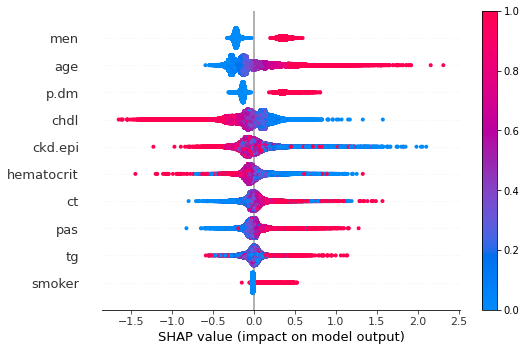

In [10]:
shap.summary_plot(shap_values, X, show=False, color_bar=False)
plt.colorbar()

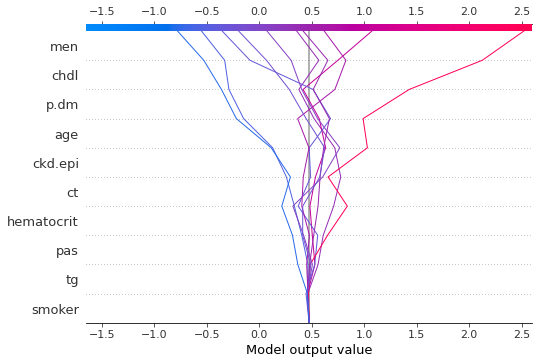

In [20]:
# Get expected value and shap values array

explainer = shap.Explainer(xgb_model)
expected_value = explainer.expected_value
shap_array = explainer.shap_values(X)

#Descion plot for first 10 observations
shap.decision_plot(expected_value, shap_array[0:10],feature_names=list(X.columns))

In [21]:
X[0:10]

,age,men,smoker,p.dm,pas,ct,chdl,tg,ckd.epi,hematocrit
0,76.0,0.0,0.0,0.0,115.0,199.0,65.0,63.0,71.290591,42.4
1,76.0,0.0,0.0,0.0,149.0,224.0,45.0,200.0,82.309140,40.8
2,79.0,1.0,0.0,0.0,130.0,210.0,33.0,246.0,54.415764,46.7
3,83.0,0.0,0.0,0.0,146.0,291.0,114.0,111.0,55.387302,39.8
4,78.0,0.0,0.0,1.0,145.0,217.0,46.0,112.0,81.160845,43.4
5,80.0,1.0,0.0,1.0,150.0,169.0,24.0,140.0,47.116106,30.3
6,77.0,0.0,0.0,0.0,124.0,274.0,60.0,97.0,67.039212,42.7
7,81.0,0.0,0.0,0.0,155.0,208.0,53.0,111.0,52.793390,38.7
8,77.0,0.0,0.0,0.0,120.0,265.0,81.0,132.0,73.322992,38.3
9,75.0,0.0,0.0,0.0,120.0,239.0,79.0,78.0,80.561347,39.3


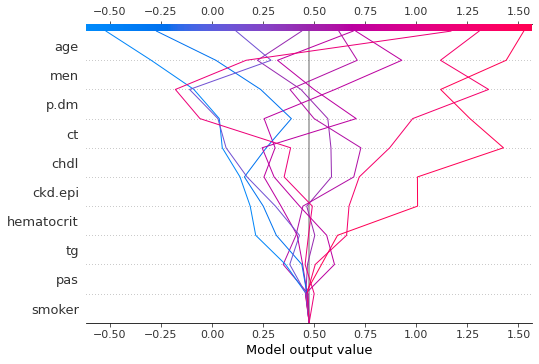

In [22]:
shap.decision_plot(expected_value, shap_array[500:510],feature_names=list(X.columns))

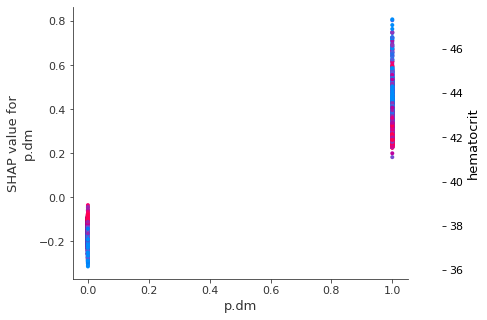

In [11]:
shap.dependence_plot("p.dm", shap_values, X)

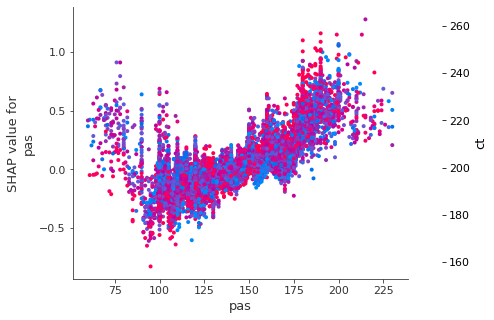

In [12]:
shap.dependence_plot("pas", shap_values, X)

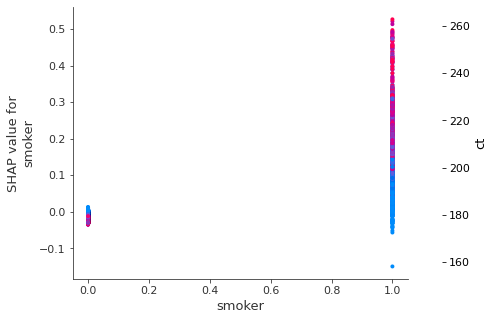

In [13]:
shap.dependence_plot("smoker", shap_values, X)

In [14]:
age = input('age:')
men = input('sex (1 for men, 0 for women):')
smoker = input('smoker (1 is smoker, 0 not smoker):')
pdm = input ('diabetes (1 is diabetic, 0 is not):')
pas = input('pas:')
ct = input('ct:')
chdl = input('chdl:')
tg = input('tg:')
# htn_med=input('hypertensive treatment (1 is being treated, 0 not):')
# charlson=input('charlson:')
ckdepi=input('renal function:')
# c10 = input('lipid-lowering treatment (1 is being treated, 0 not):')
hematocrit = input('hematocrit:')

df2 = {'age': float(age),
       'men': float(men), 
       'smoker': float(smoker),
       'p.dm': float(pdm),
       'pas': float(pas),
       'ct': float(ct),
       'chdl': float(chdl),
       'tg':float(tg),
       # 'htn_med':float(htn_med),
       # 'charlson':float(charlson),
       'ckd.epi':float(ckdepi),
       # 'c10':float(c10),
       'hematocrit':float(hematocrit)}

X = X.append(df2, ignore_index = True)

shap.initjs()
explainerModel = shap.TreeExplainer(xgb_model)
shap_values_Model = explainerModel.shap_values(X.iloc[[-1]])
a = shap.force_plot(explainerModel.expected_value, shap_values_Model[-1], X.iloc[[-1]])

X.drop(X.tail(1).index,inplace=True)

age:90
sex (1 for men, 0 for women):1
smoker (1 is smoker, 0 not smoker):0
diabetes (1 is diabetic, 0 is not):0
pas:125
ct:150
chdl:70
tg:140
renal function:40
hematocrit:40


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [15]:
a

In [16]:
X

,age,men,smoker,p.dm,pas,ct,chdl,tg,ckd.epi,hematocrit
0,76.0,0.0,0.0,0.0,115.0,199.0,65.0,63.0,71.290591,42.4
1,76.0,0.0,0.0,0.0,149.0,224.0,45.0,200.0,82.309140,40.8
2,79.0,1.0,0.0,0.0,130.0,210.0,33.0,246.0,54.415764,46.7
3,83.0,0.0,0.0,0.0,146.0,291.0,114.0,111.0,55.387302,39.8
4,78.0,0.0,0.0,1.0,145.0,217.0,46.0,112.0,81.160845,43.4
...,...,...,...,...,...,...,...,...,...,...
109298,77.0,0.0,0.0,0.0,132.0,304.0,97.0,109.0,67.039212,39.0
109299,75.0,0.0,0.0,0.0,143.0,212.0,69.0,70.0,78.477076,43.8
109300,85.0,0.0,0.0,0.0,178.0,166.0,58.0,93.0,77.266511,42.4
109301,85.0,1.0,0.0,0.0,110.0,165.0,49.0,75.0,73.727877,38.2
